In [1]:
import matplotlib.pyplot as plt
import numpy as np
import numpy.matlib
import pandas as pd
import sklearn
import statsmodels.api as sm
import statsmodels.formula.api as smf
#import boto3
import io
from io import StringIO

from numpy import linalg
from scipy.stats import *
from scipy.stats import binom, beta, expon, mvn, randint as sp_randint, shapiro, ttest_ind, bernoulli
from sklearn import metrics
from sklearn.calibration import calibration_curve
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression, LogisticRegression, Ridge, Lasso, SGDClassifier
#from statsmodels.tools.eval_measures import rmse, aic
from sklearn.preprocessing import StandardScaler

import utils
from pytest import approx

In [2]:
np.set_printoptions(precision=3, suppress=True)

In [3]:
#s3client = boto3.client(
#    's3',
#    region_name='us-east-1'
#

#bucketname = "bucketmno2020arenitss"
#file_to_read = "data_t_final.csv"

#fileobj = s3client.get_object(
#    Bucket=bucketname,
#    Key=file_to_read
#    )


In [4]:
df = pd.read_csv('/Users/yedam/Documents/Maestria Ciencia de Datos/Primer Semestre/Optimizacion/Proyecto Final/data_t_final.csv')

In [5]:
#contenido = fileobj['Body'].read()

#contenido = filedata.decode('utf-8')

#type(contenido)

#StringData = StringIO(contenido)

#df = pd.read_csv(StringData)

In [6]:
#df

In [7]:
data = df.dropna(subset=['time', 'default_time','LTV_time', 'FICO_orig_time']).copy()

In [8]:
for col in data.columns: 
    print(col)

id
time
orig_time
first_time
mat_time
res_time
balance_time
LTV_time
interest_rate_time
rate_time
hpi_time
gdp_time
uer_time
REtype_CO_orig_time
REtype_PU_orig_time
REtype_SF_orig_time
investor_orig_time
balance_orig_time
FICO_orig_time
LTV_orig_time
Interest_Rate_orig_time
state_orig_time
hpi_orig_time
default_time
payoff_time
status_time
lgd_time
recovery_res


In [9]:
data.head()

,id,time,orig_time,first_time,mat_time,res_time,balance_time,LTV_time,interest_rate_time,rate_time,...,FICO_orig_time,LTV_orig_time,Interest_Rate_orig_time,state_orig_time,hpi_orig_time,default_time,payoff_time,status_time,lgd_time,recovery_res
0,4,25,-2,25,119,NaN,61031.10,33.911009,10.500,5.9,...,587,81.8,10.5,KY,97.99,0,0,0,NaN,NaN
1,4,26,-2,25,119,NaN,60882.42,34.007232,10.500,5.9,...,587,81.8,10.5,KY,97.99,0,0,0,NaN,NaN
2,4,27,-2,25,119,NaN,60729.80,34.335349,10.500,5.9,...,587,81.8,10.5,KY,97.99,0,0,0,NaN,NaN
3,4,28,-2,25,119,NaN,60576.14,34.672545,10.875,5.9,...,587,81.8,10.5,KY,97.99,0,0,0,NaN,NaN
4,4,29,-2,25,119,NaN,60424.39,34.951639,10.875,5.9,...,587,81.8,10.5,KY,97.99,0,0,0,NaN,NaN


In [57]:
fitted_values , model = utils.estim_prob(data,['default_time', 'balance_time','interest_rate_time',
                                               'rate_time','hpi_time',
                                               'gdp_time','uer_time','REtype_CO_orig_time','REtype_SF_orig_time',
                                               'investor_orig_time','balance_orig_time','FICO_orig_time','LTV_orig_time',
                                               'Interest_Rate_orig_time','hpi_orig_time','LTV_time'])

62153
Evaluación de valor óptimo al resolver problema de optimización 13296.454946928172


In [ ]:
model_lr = smf.glm('default_time ~   balance_time + interest_rate_time + rate_time + hpi_time + uer_time + REtype_CO_orig_time + gdp_time + REtype_SF_orig_time + investor_orig_time + balance_orig_time + FICO_orig_time + LTV_orig_time + Interest_Rate_orig_time + hpi_orig_time + LTV_time ', family = sm.families.Binomial(), data = data).fit()

In [47]:
print(model == approx(np.array(model_lr.params), abs=1e-1, rel=1e-1))

True


In [15]:
print(model_lr.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:           default_time   No. Observations:                62153
Model:                            GLM   Df Residuals:                    62137
Model Family:                Binomial   Df Model:                           15
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -6648.2
Date:                Mon, 07 Dec 2020   Deviance:                       13296.
Time:                        22:55:41   Pearson chi2:                 5.76e+04
No. Iterations:                     8                                         
Covariance Type:            nonrobust                                         
                              coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                 

In [53]:
PD_logit_model = pd.DataFrame(fitted_values, columns=['PD_logit_model'])

In [54]:
data2 = pd.merge(df[['default_time','time']],PD_logit_model, right_index=True, left_index=True)

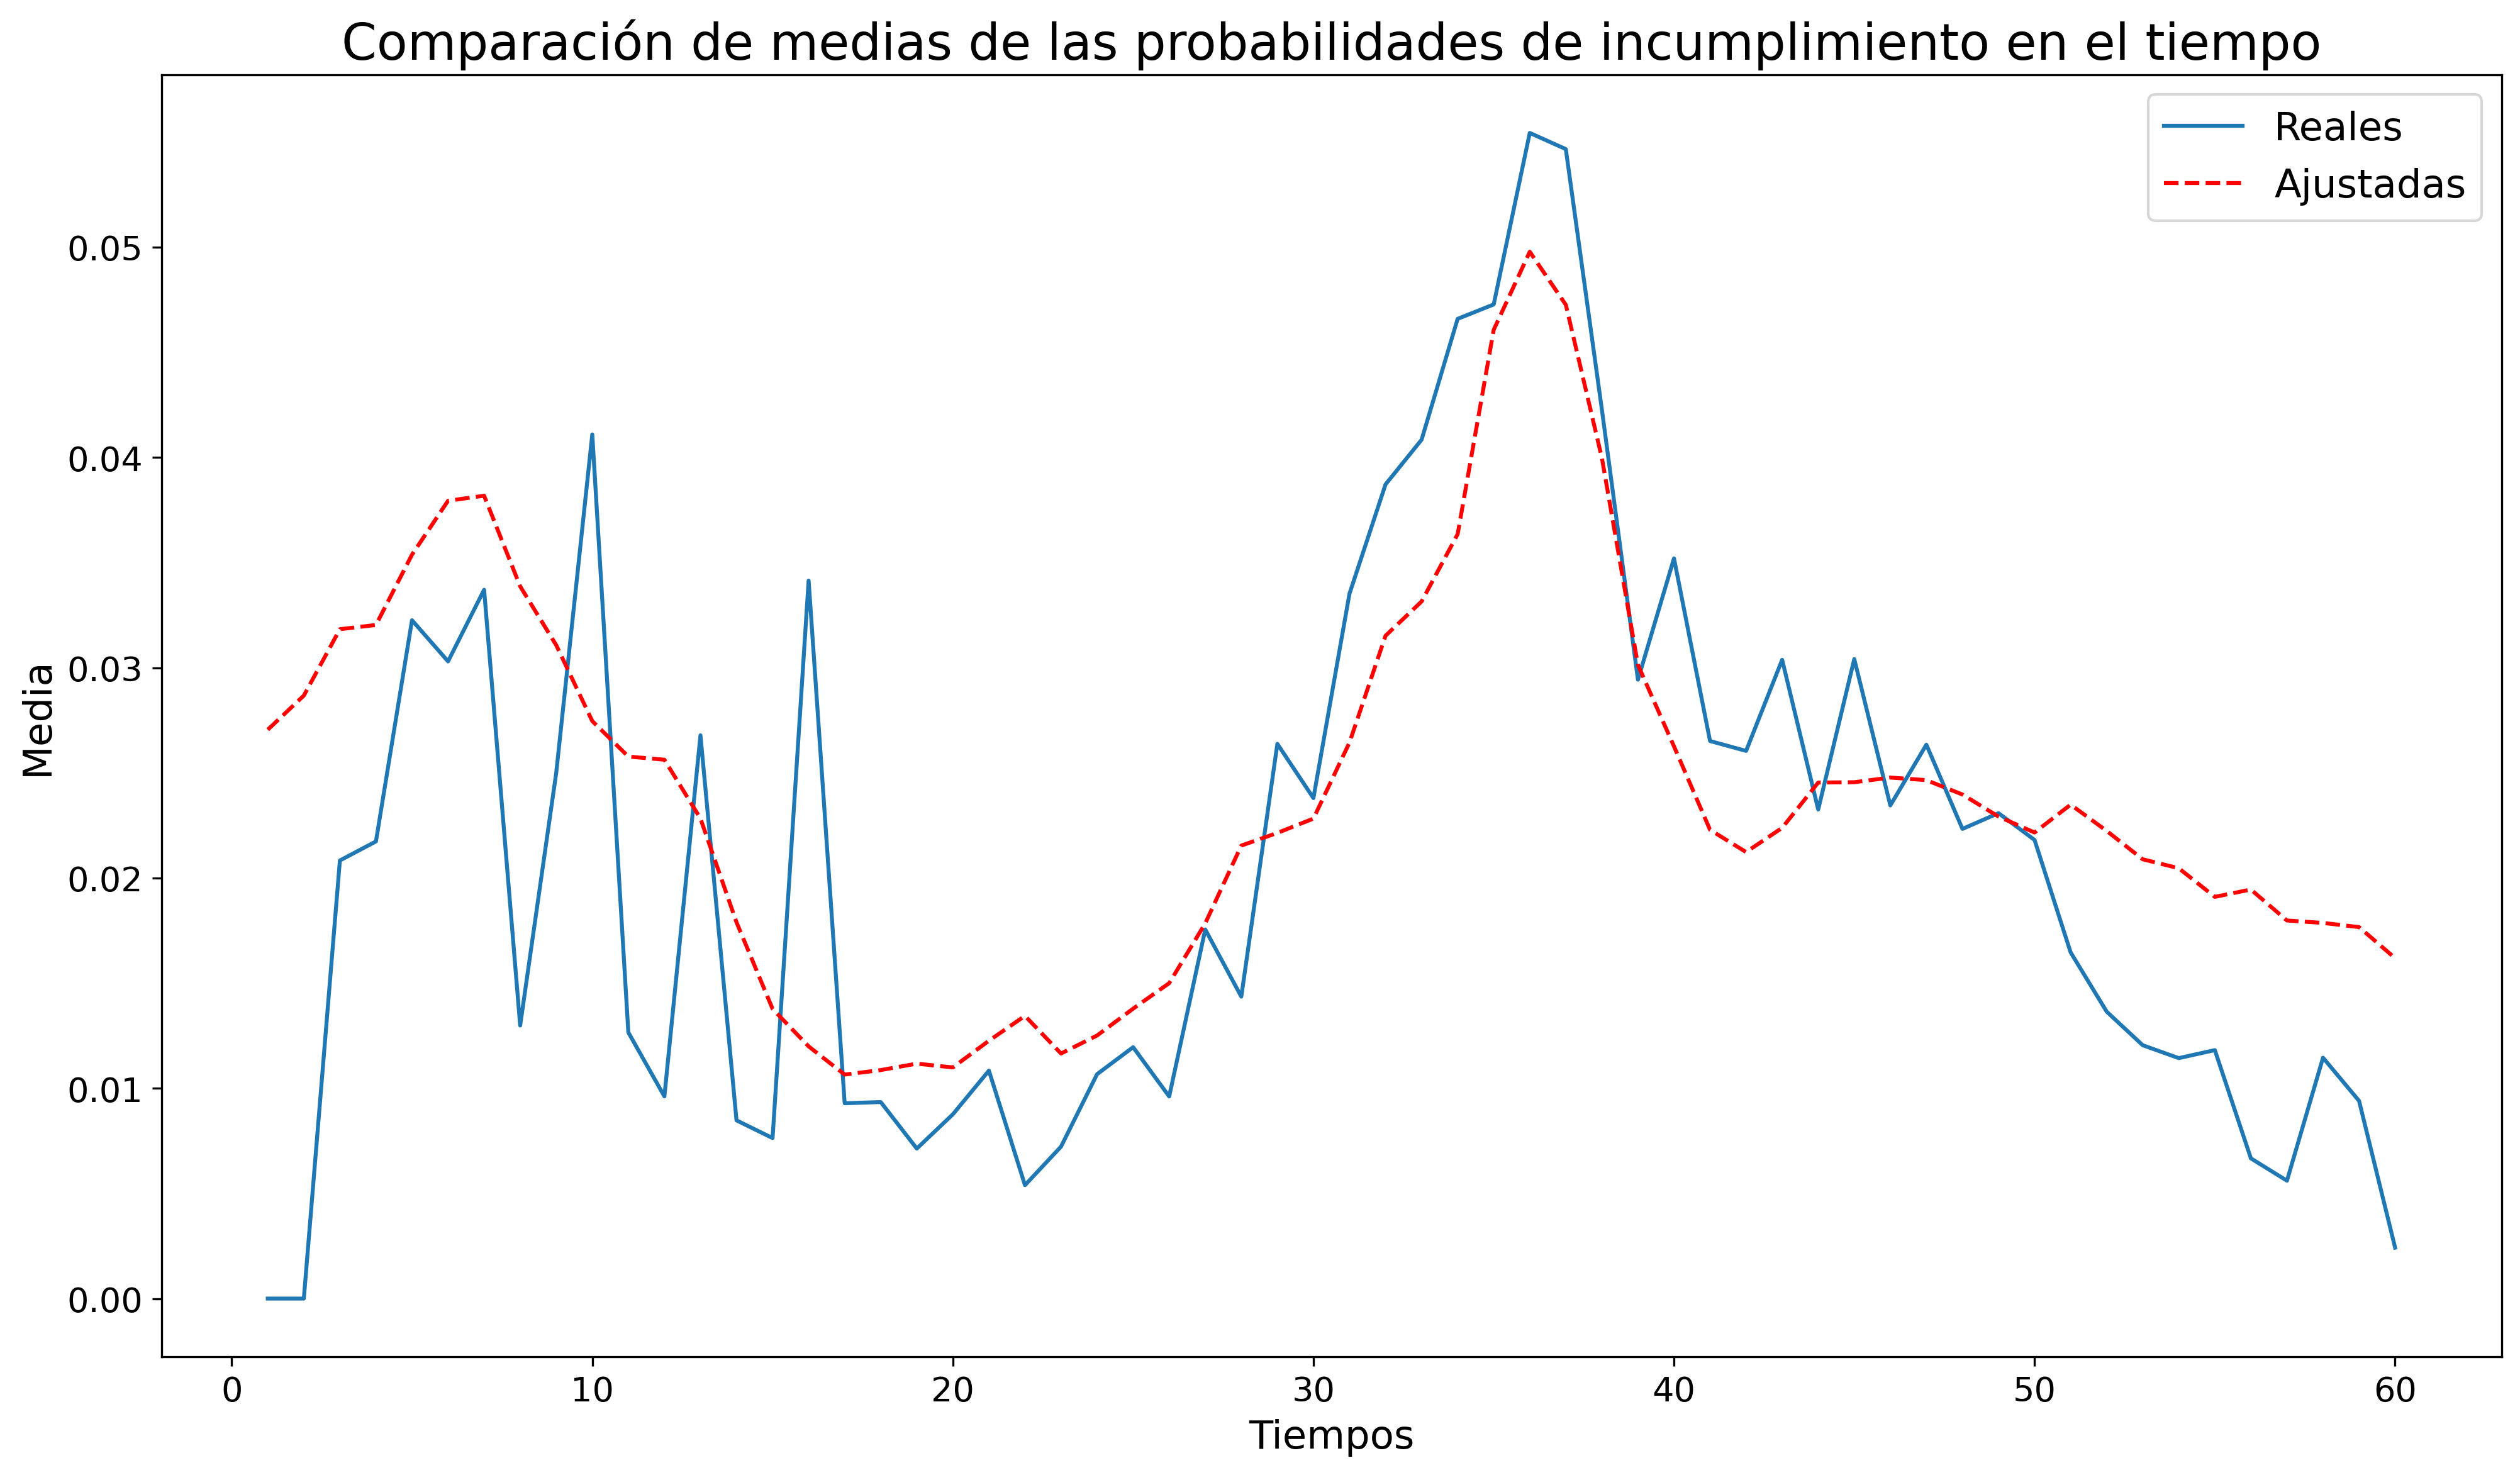

In [59]:
utils.grafica_medias(data2.PD_logit_model, data2.default_time, data2.time)

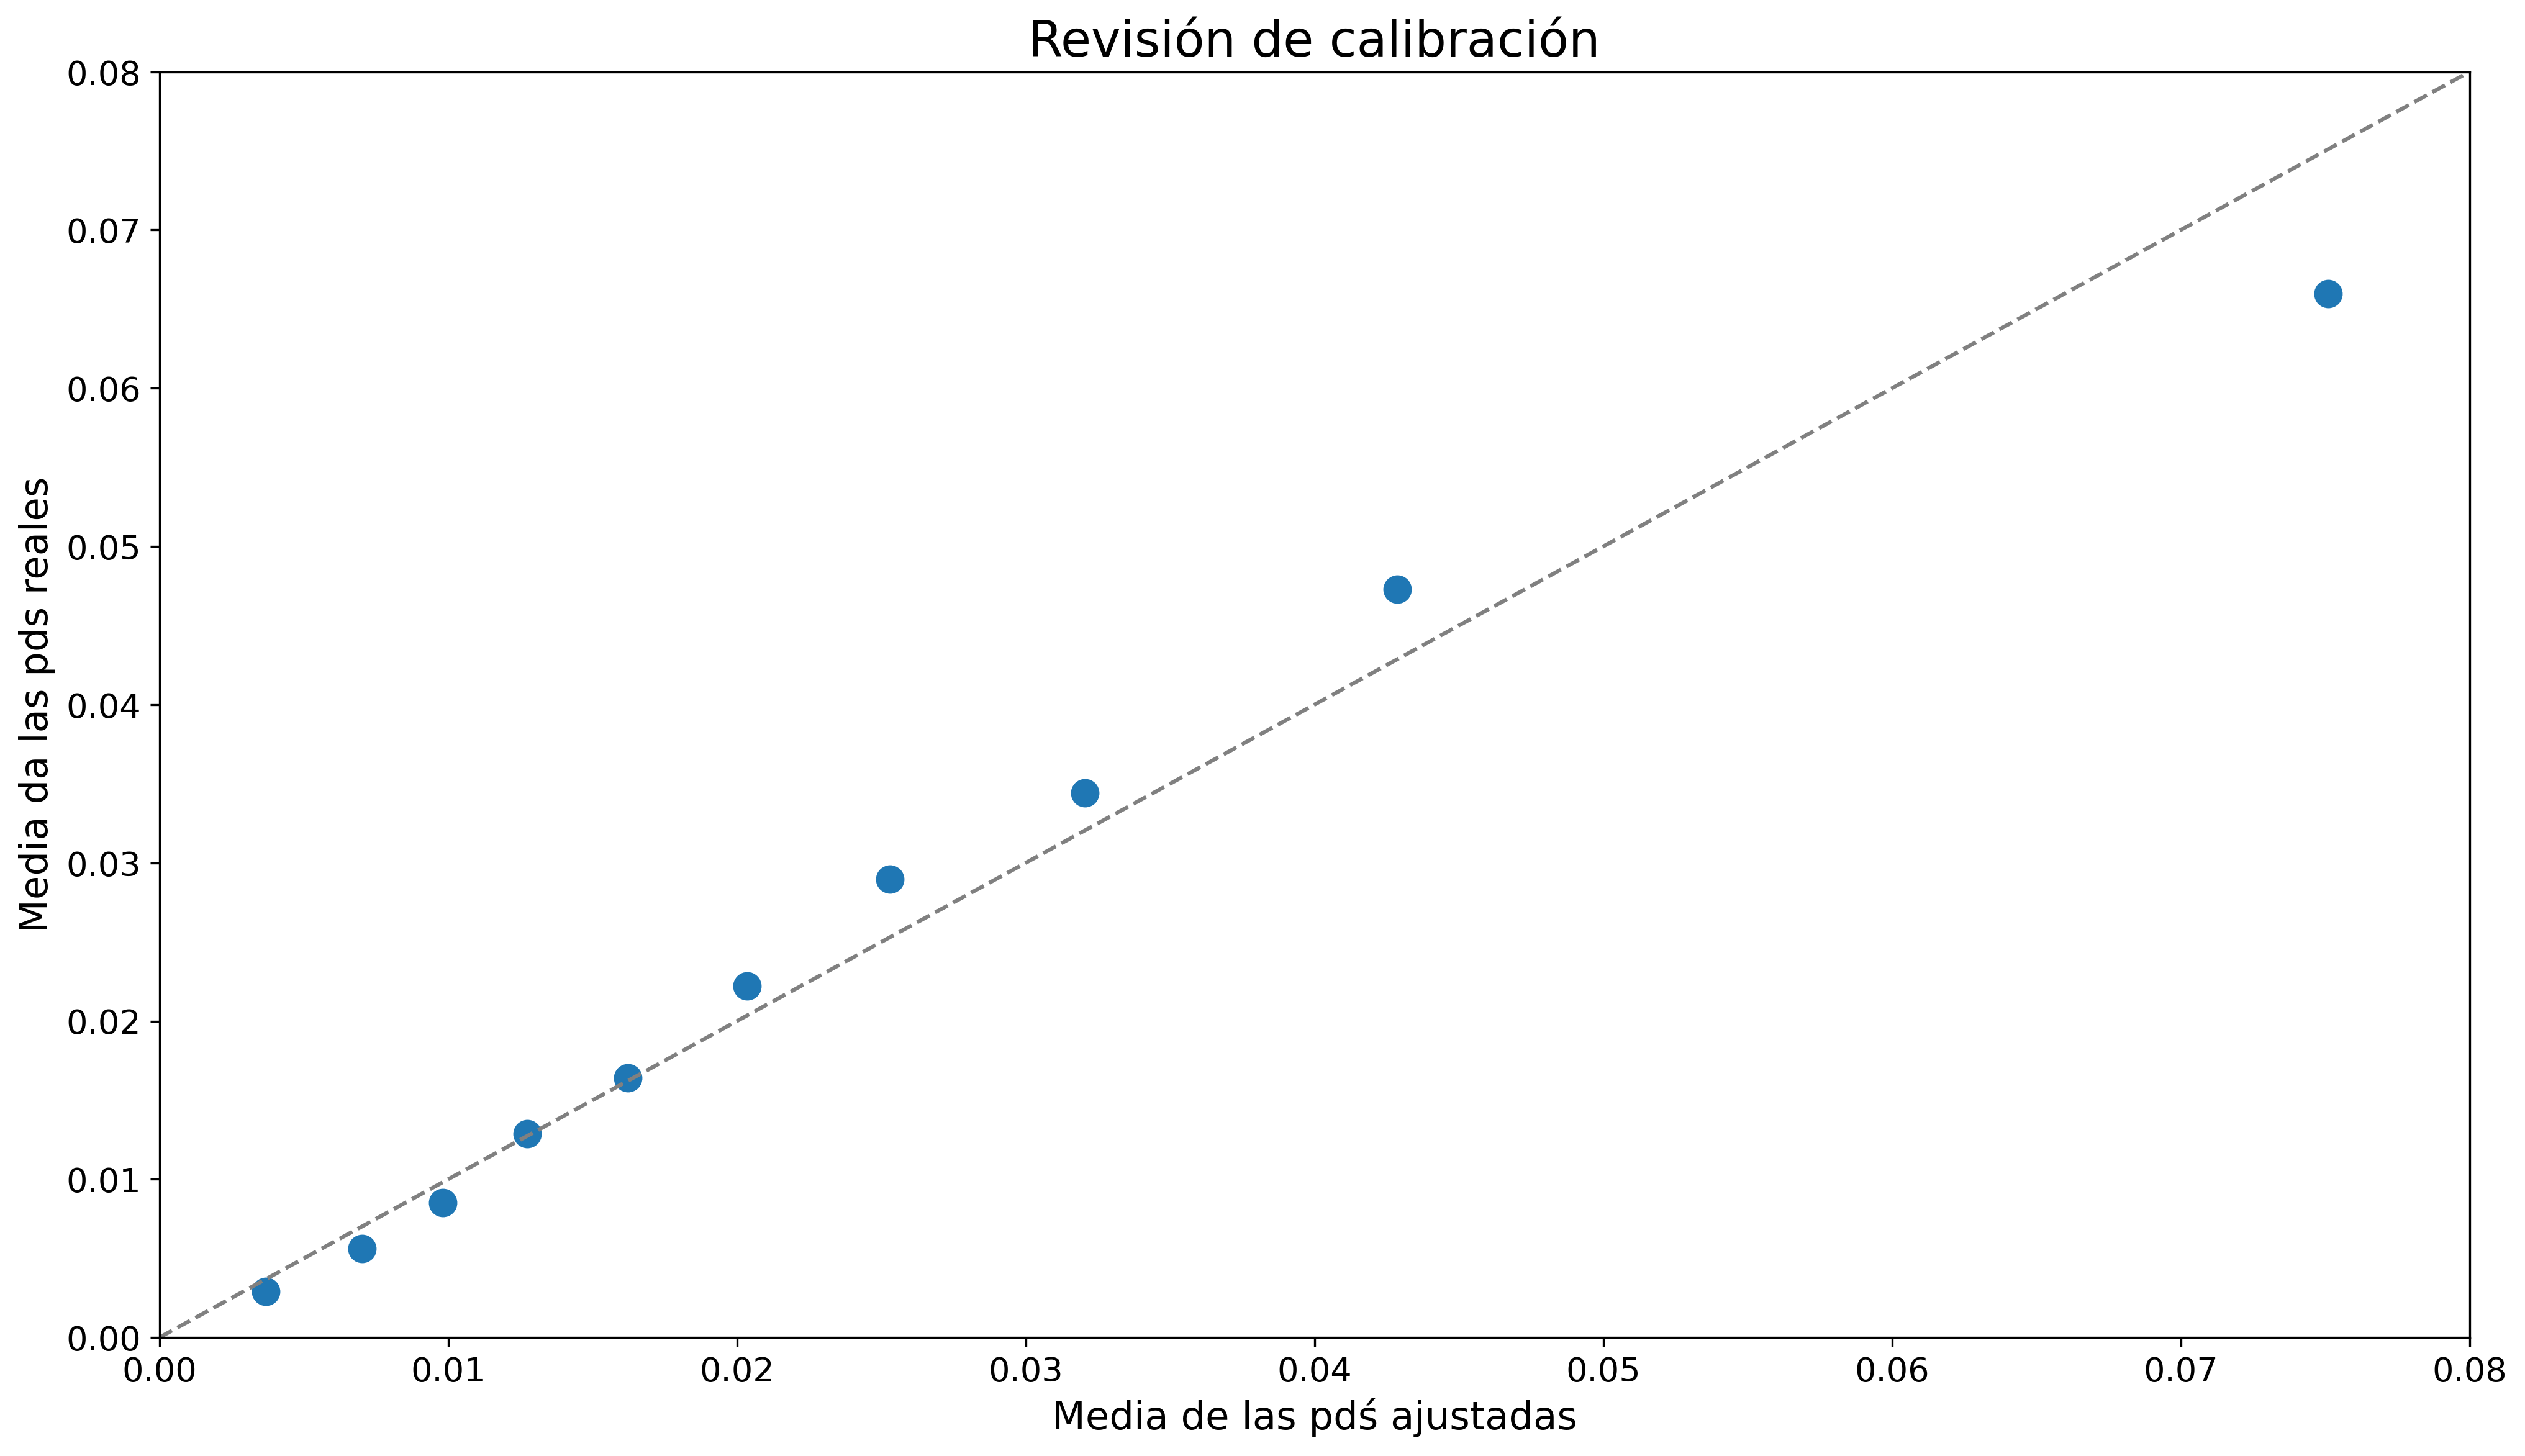

In [60]:
utils.grafica_ajuste(data2.PD_logit_model, data2.default_time, data2.time)

In [260]:
defaultrates_states1 = data.groupby(['time','state_orig_time'])['default_time'].mean().unstack(level=1).add_prefix('defaultrate_').fillna(0).reset_index(drop=False)
scaler = StandardScaler()
defaultrates_states = scaler.fit_transform(defaultrates_states1)
cov = np.cov(defaultrates_states.T)

In [261]:
eigenvalor,eigenvector = utils.potencia(cov,MAX=1000)
eigenvalor2,eigenvector2 = utils.deflacion(cov,MAX=1000)

In [262]:
cp1 = eigenvector@defaultrates_states.T
cp2 = eigenvector2@defaultrates_states.T

In [263]:
pca=PCA()
pca.fit(defaultrates_states)
z = pca.transform(defaultrates_states)

In [264]:
print(cp1 == approx(z[:,0], abs=1e-2, rel=1e-2))

True


In [265]:
print(-cp2 == approx(z[:,1], abs=1e-2, rel=1e-2))

True


<function matplotlib.pyplot.show(close=None, block=None)>

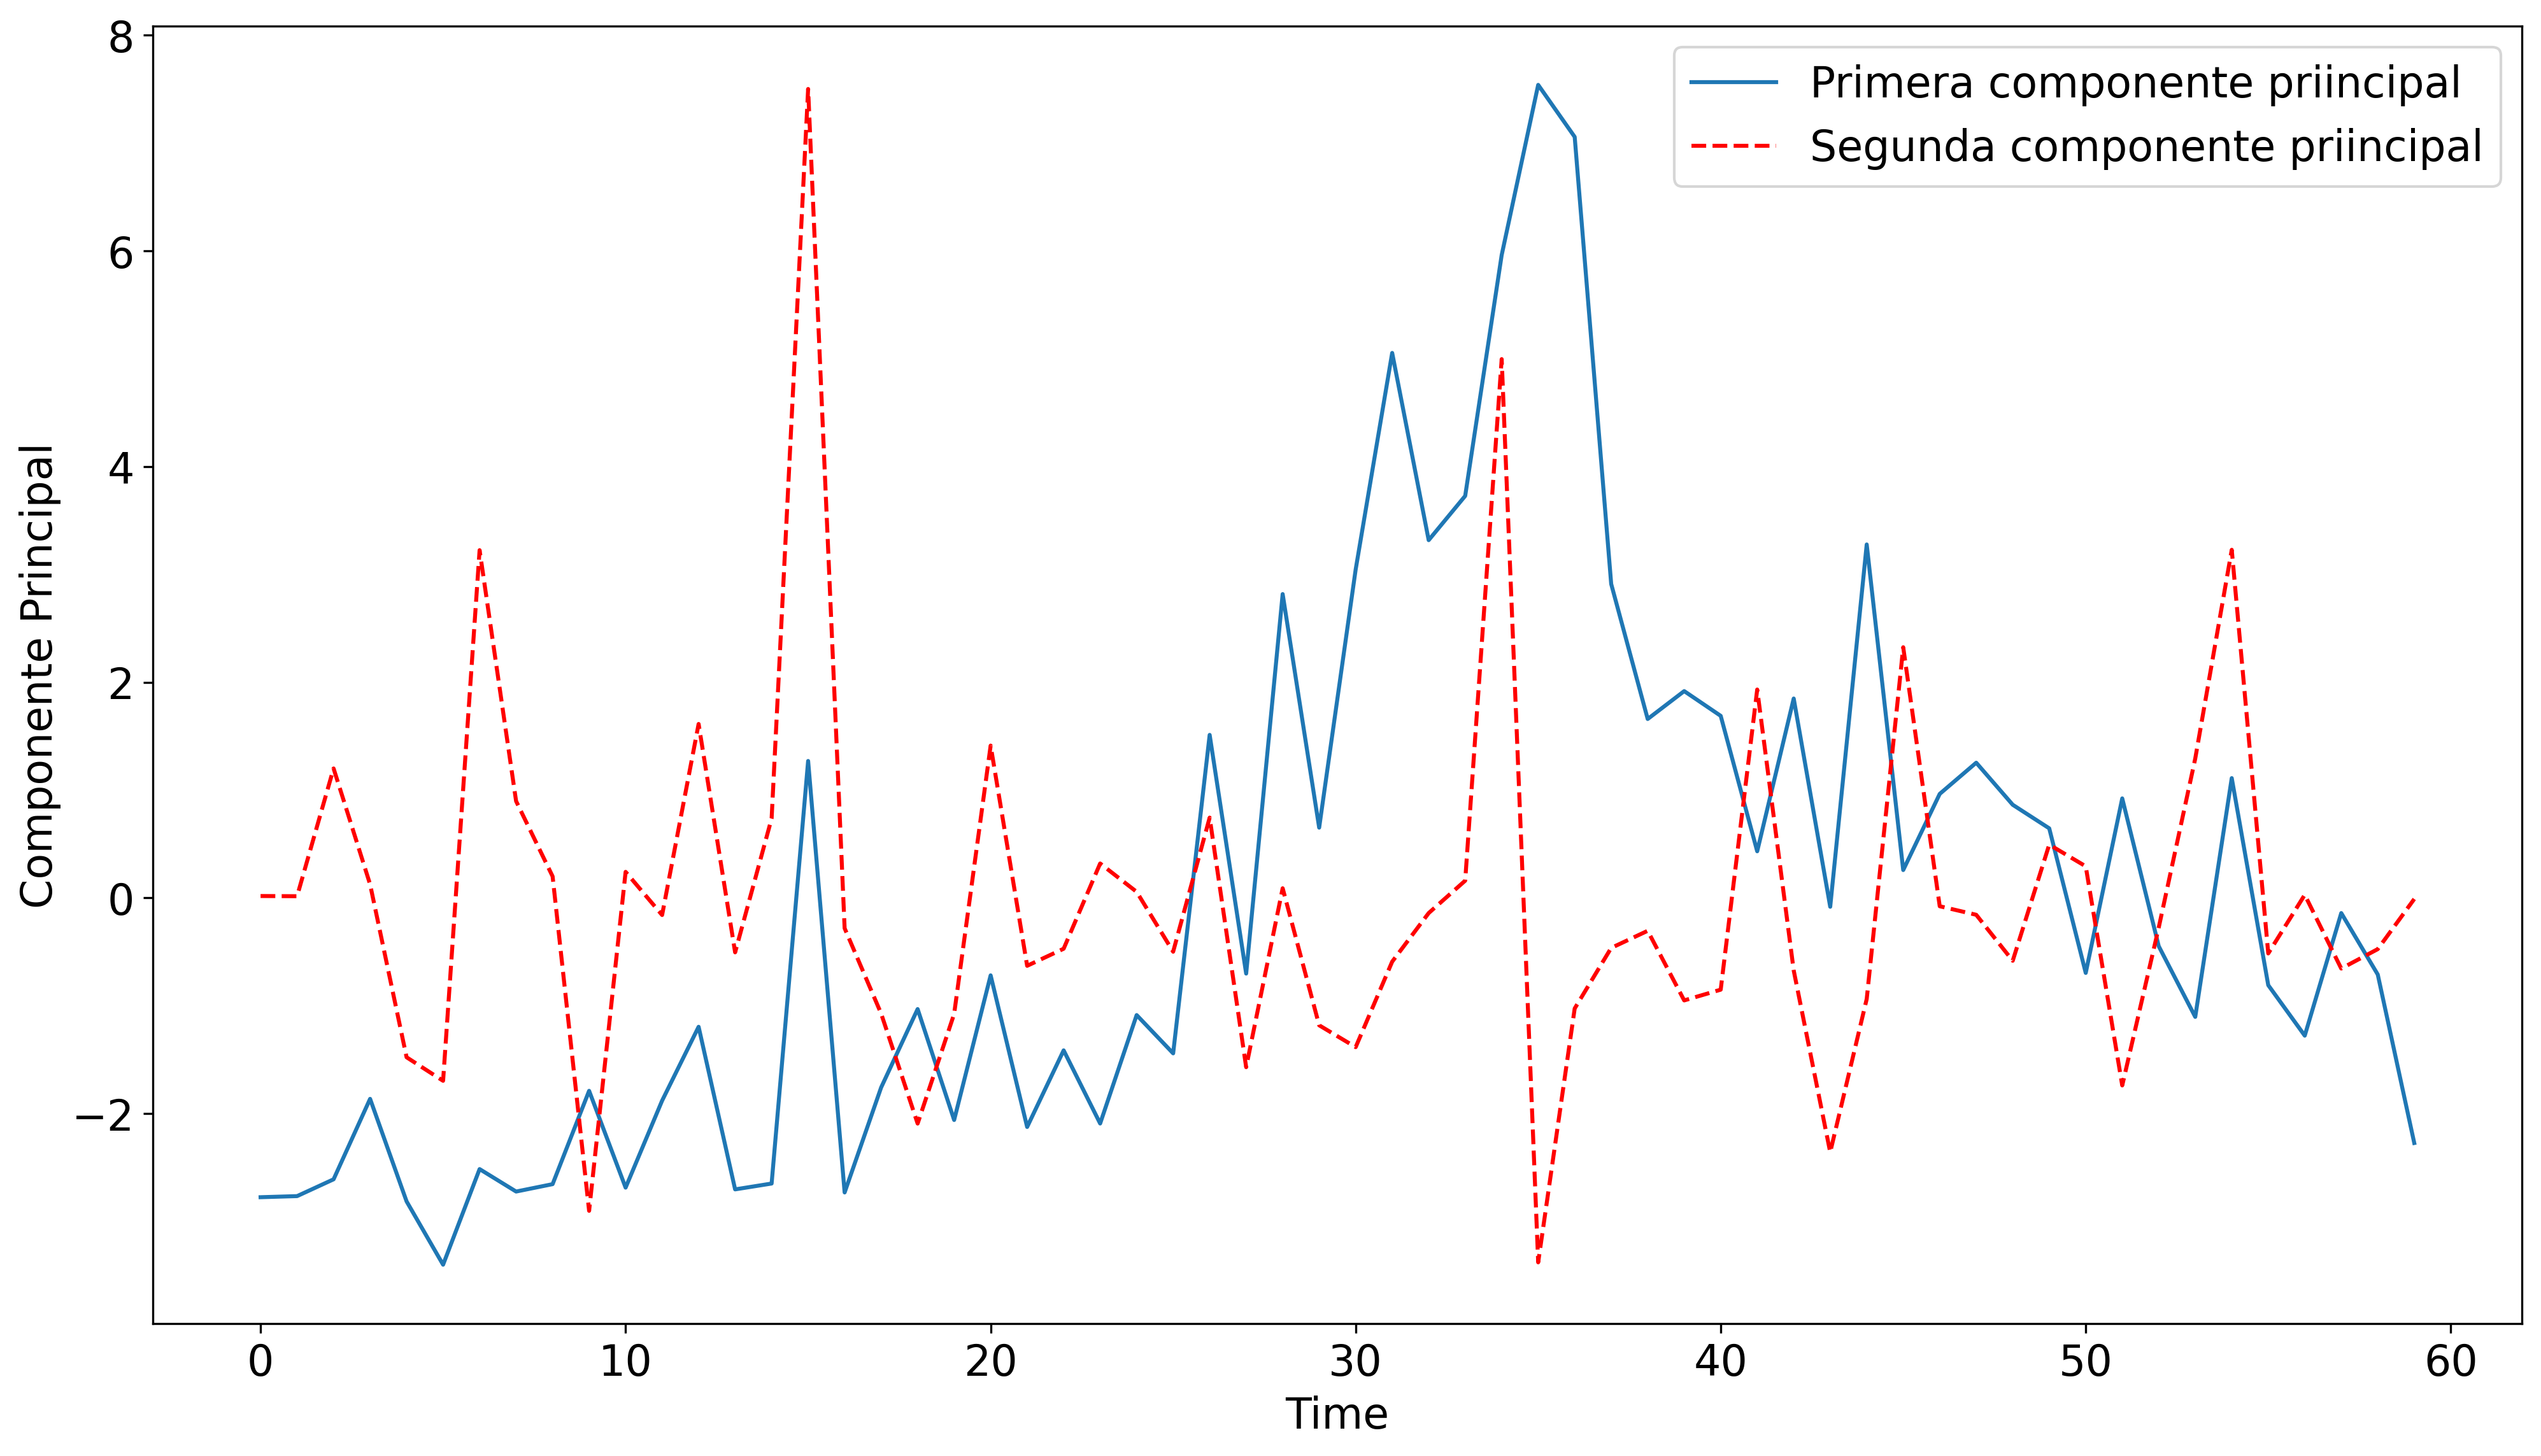

In [266]:
z = pca.transform(defaultrates_states)

plt.xlabel('Time')
plt.ylabel('Componente Principal')
plt.plot(defaultrates_states1.index, cp1, alpha =1, label = "Primera componente priincipal")
plt.plot(defaultrates_states1.index, -cp2, alpha =1, color = 'red', linestyle = 'dashed', label = "Segunda componente priincipal")
plt.legend(loc='best')
plt.show

In [267]:
cpa = pd.DataFrame(pd.DataFrame([cp1,-cp2,defaultrates_states1['time']]).T)
cpa = A.rename(columns={0:'cpa1',1:'cpa2',2:'time' })
data_cpa = pd.merge(data,cpa,left_on='time',right_on='time')

In [268]:
fitted_values_cpa , model_cpa = utils.estim_prob(data_cpa,['default_time', 'balance_time','interest_rate_time',
                                               'rate_time','hpi_time',
                                               'gdp_time','uer_time','REtype_CO_orig_time','REtype_SF_orig_time',
                                               'investor_orig_time','balance_orig_time','FICO_orig_time','LTV_orig_time',
                                               'Interest_Rate_orig_time','hpi_orig_time','LTV_time','cp1','cp2'])

62153
Evaluación de valor óptimo al resolver problema de optimización 13243.329271891453


In [269]:
model_lr_cpa = smf.glm('default_time ~   balance_time + interest_rate_time + rate_time + hpi_time + gdp_time + uer_time + REtype_CO_orig_time + REtype_SF_orig_time + investor_orig_time + balance_orig_time + FICO_orig_time + LTV_orig_time + Interest_Rate_orig_time + hpi_orig_time + LTV_time + cp1 + cp2', family = sm.families.Binomial(), data = data_cpa).fit()

In [270]:
print(model_cpa == approx(np.array(model_lr_cpa.params), abs=1e-3, rel=1e-3))

True


In [271]:
print(model_lr_cpa.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:           default_time   No. Observations:                62153
Model:                            GLM   Df Residuals:                    62135
Model Family:                Binomial   Df Model:                           17
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -6621.7
Date:                Tue, 08 Dec 2020   Deviance:                       13243.
Time:                        01:03:39   Pearson chi2:                 5.73e+04
No. Iterations:                     8                                         
Covariance Type:            nonrobust                                         
                              coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                 

In [272]:
PD_logit_model_cpa = pd.DataFrame(fitted_values_cpa, columns=['PD_logit_model'])

In [273]:
data2_cpa = pd.merge(df[['default_time','time']],PD_logit_model_cpa, right_index=True, left_index=True)

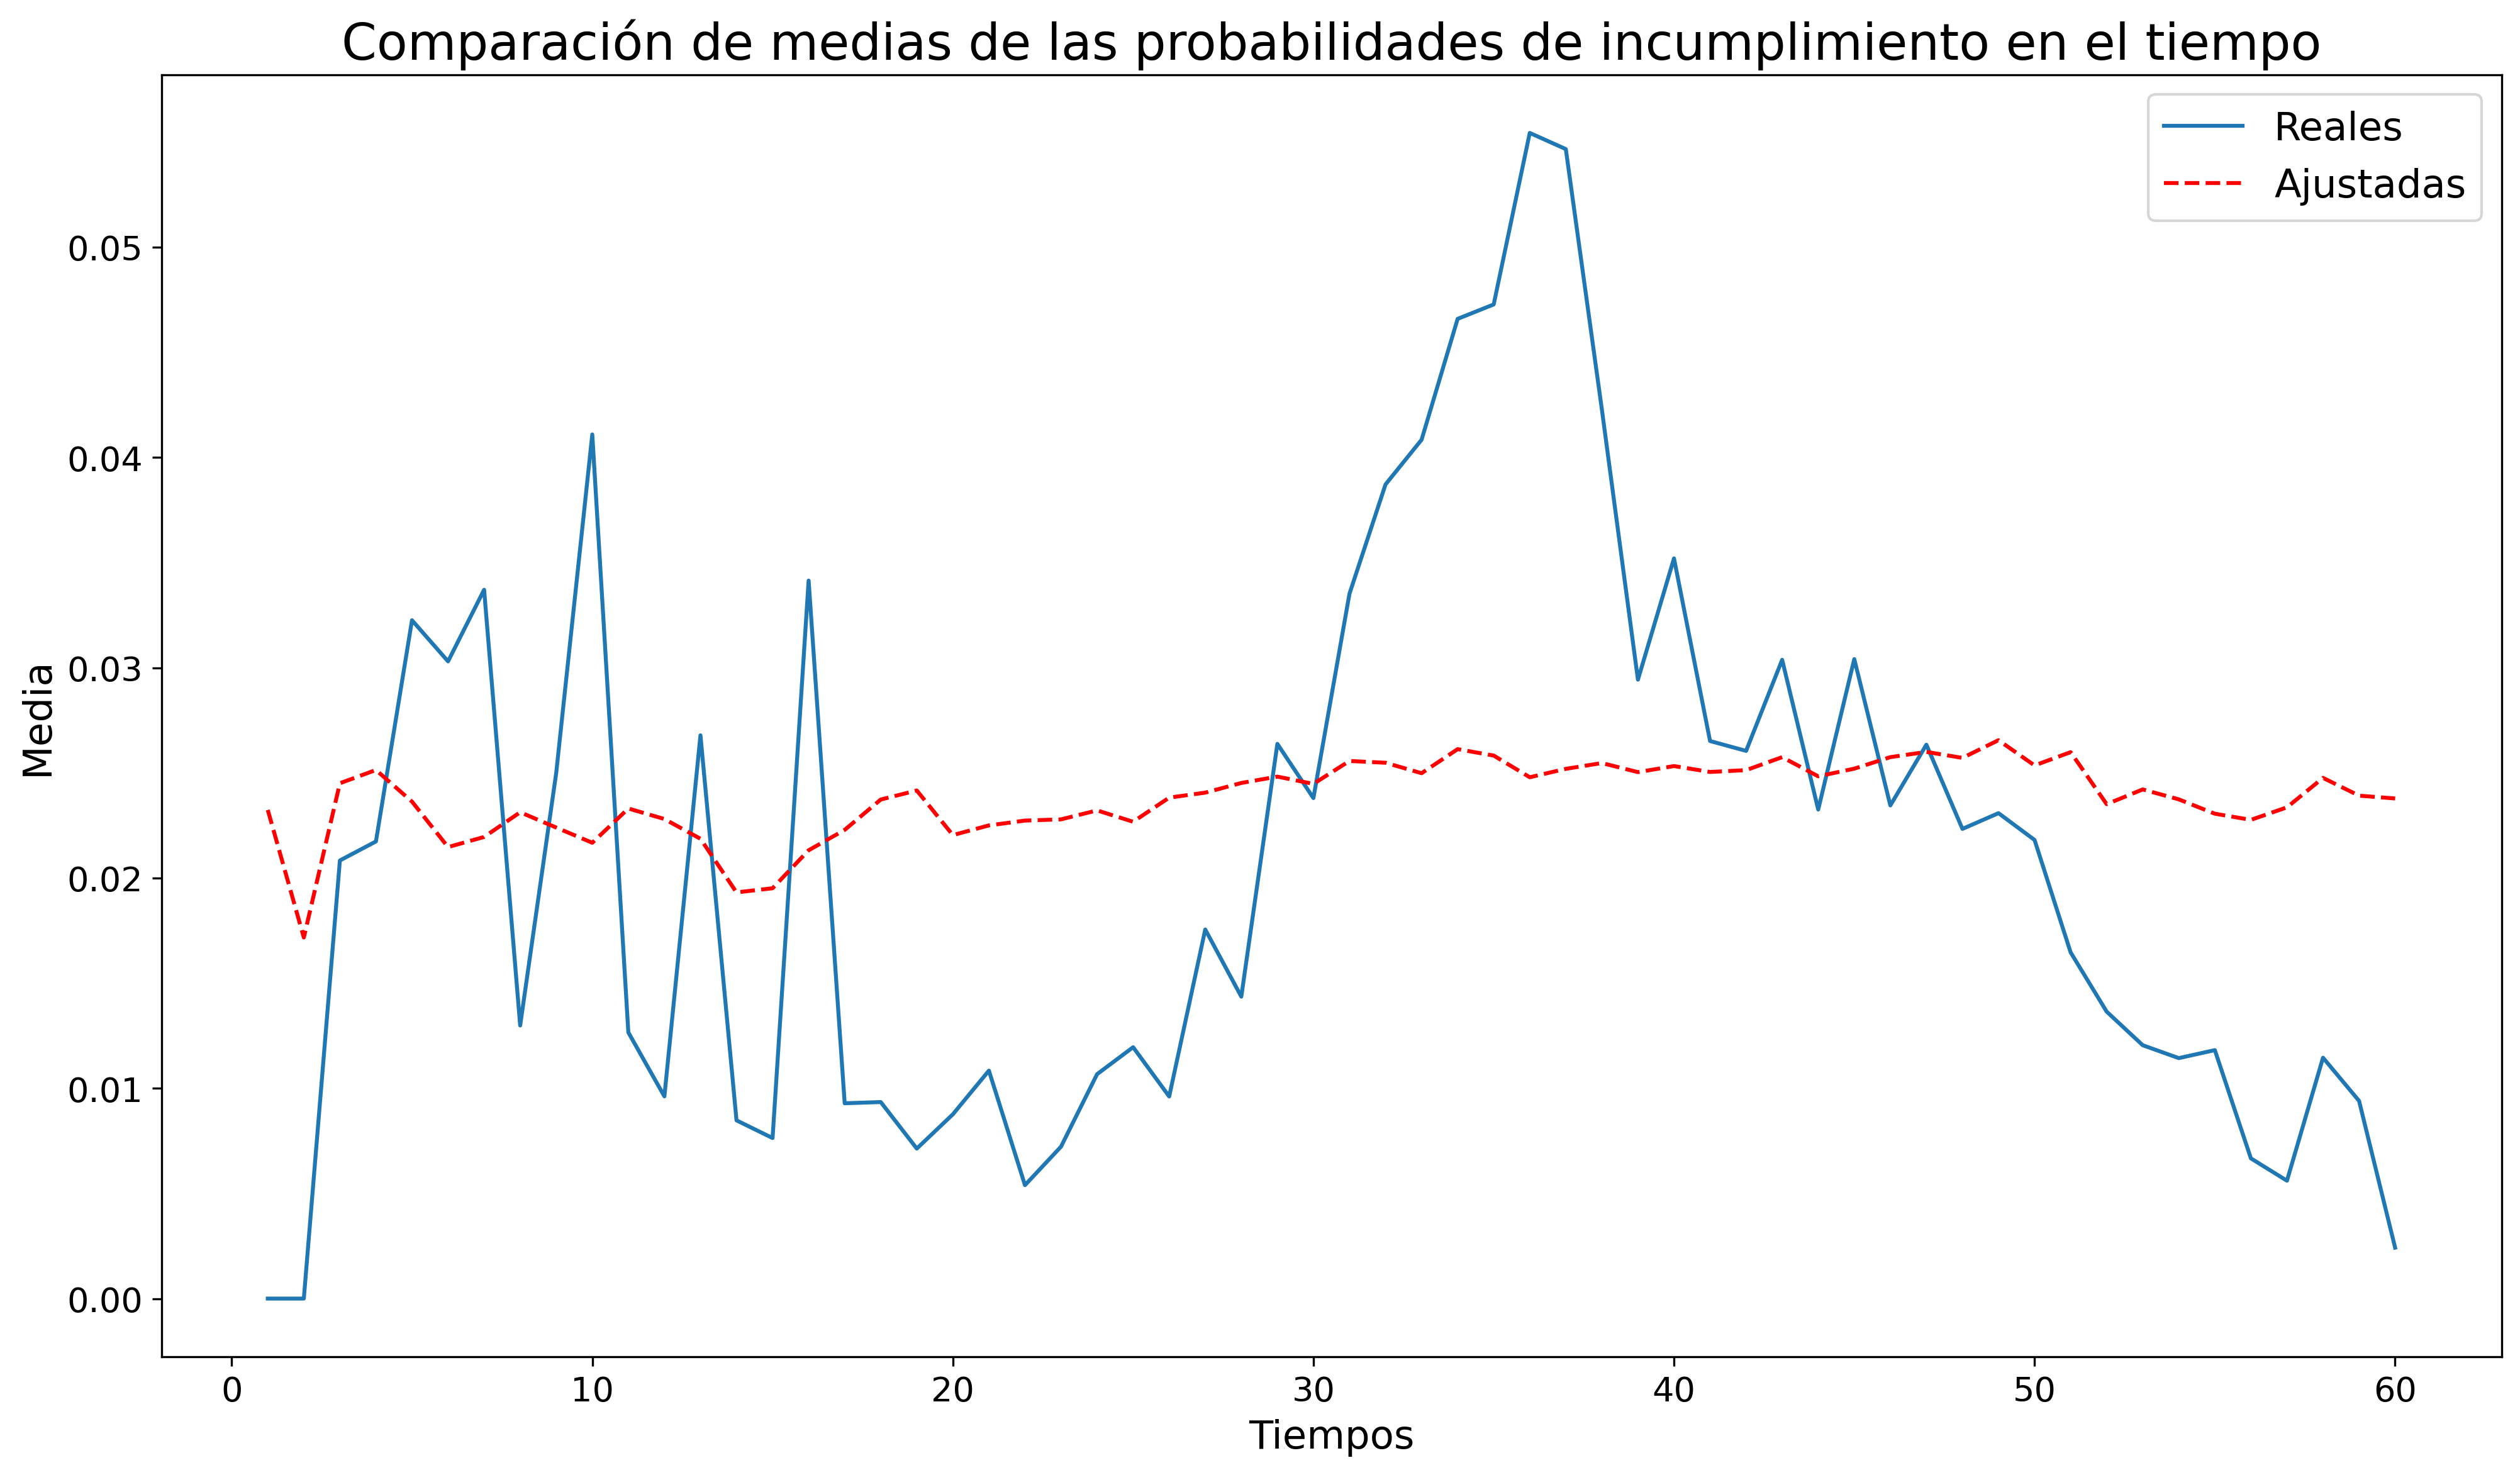

In [274]:
utils.grafica_medias(data2_cpa.PD_logit_model, data2_cpa.default_time, data2_cpa.time)

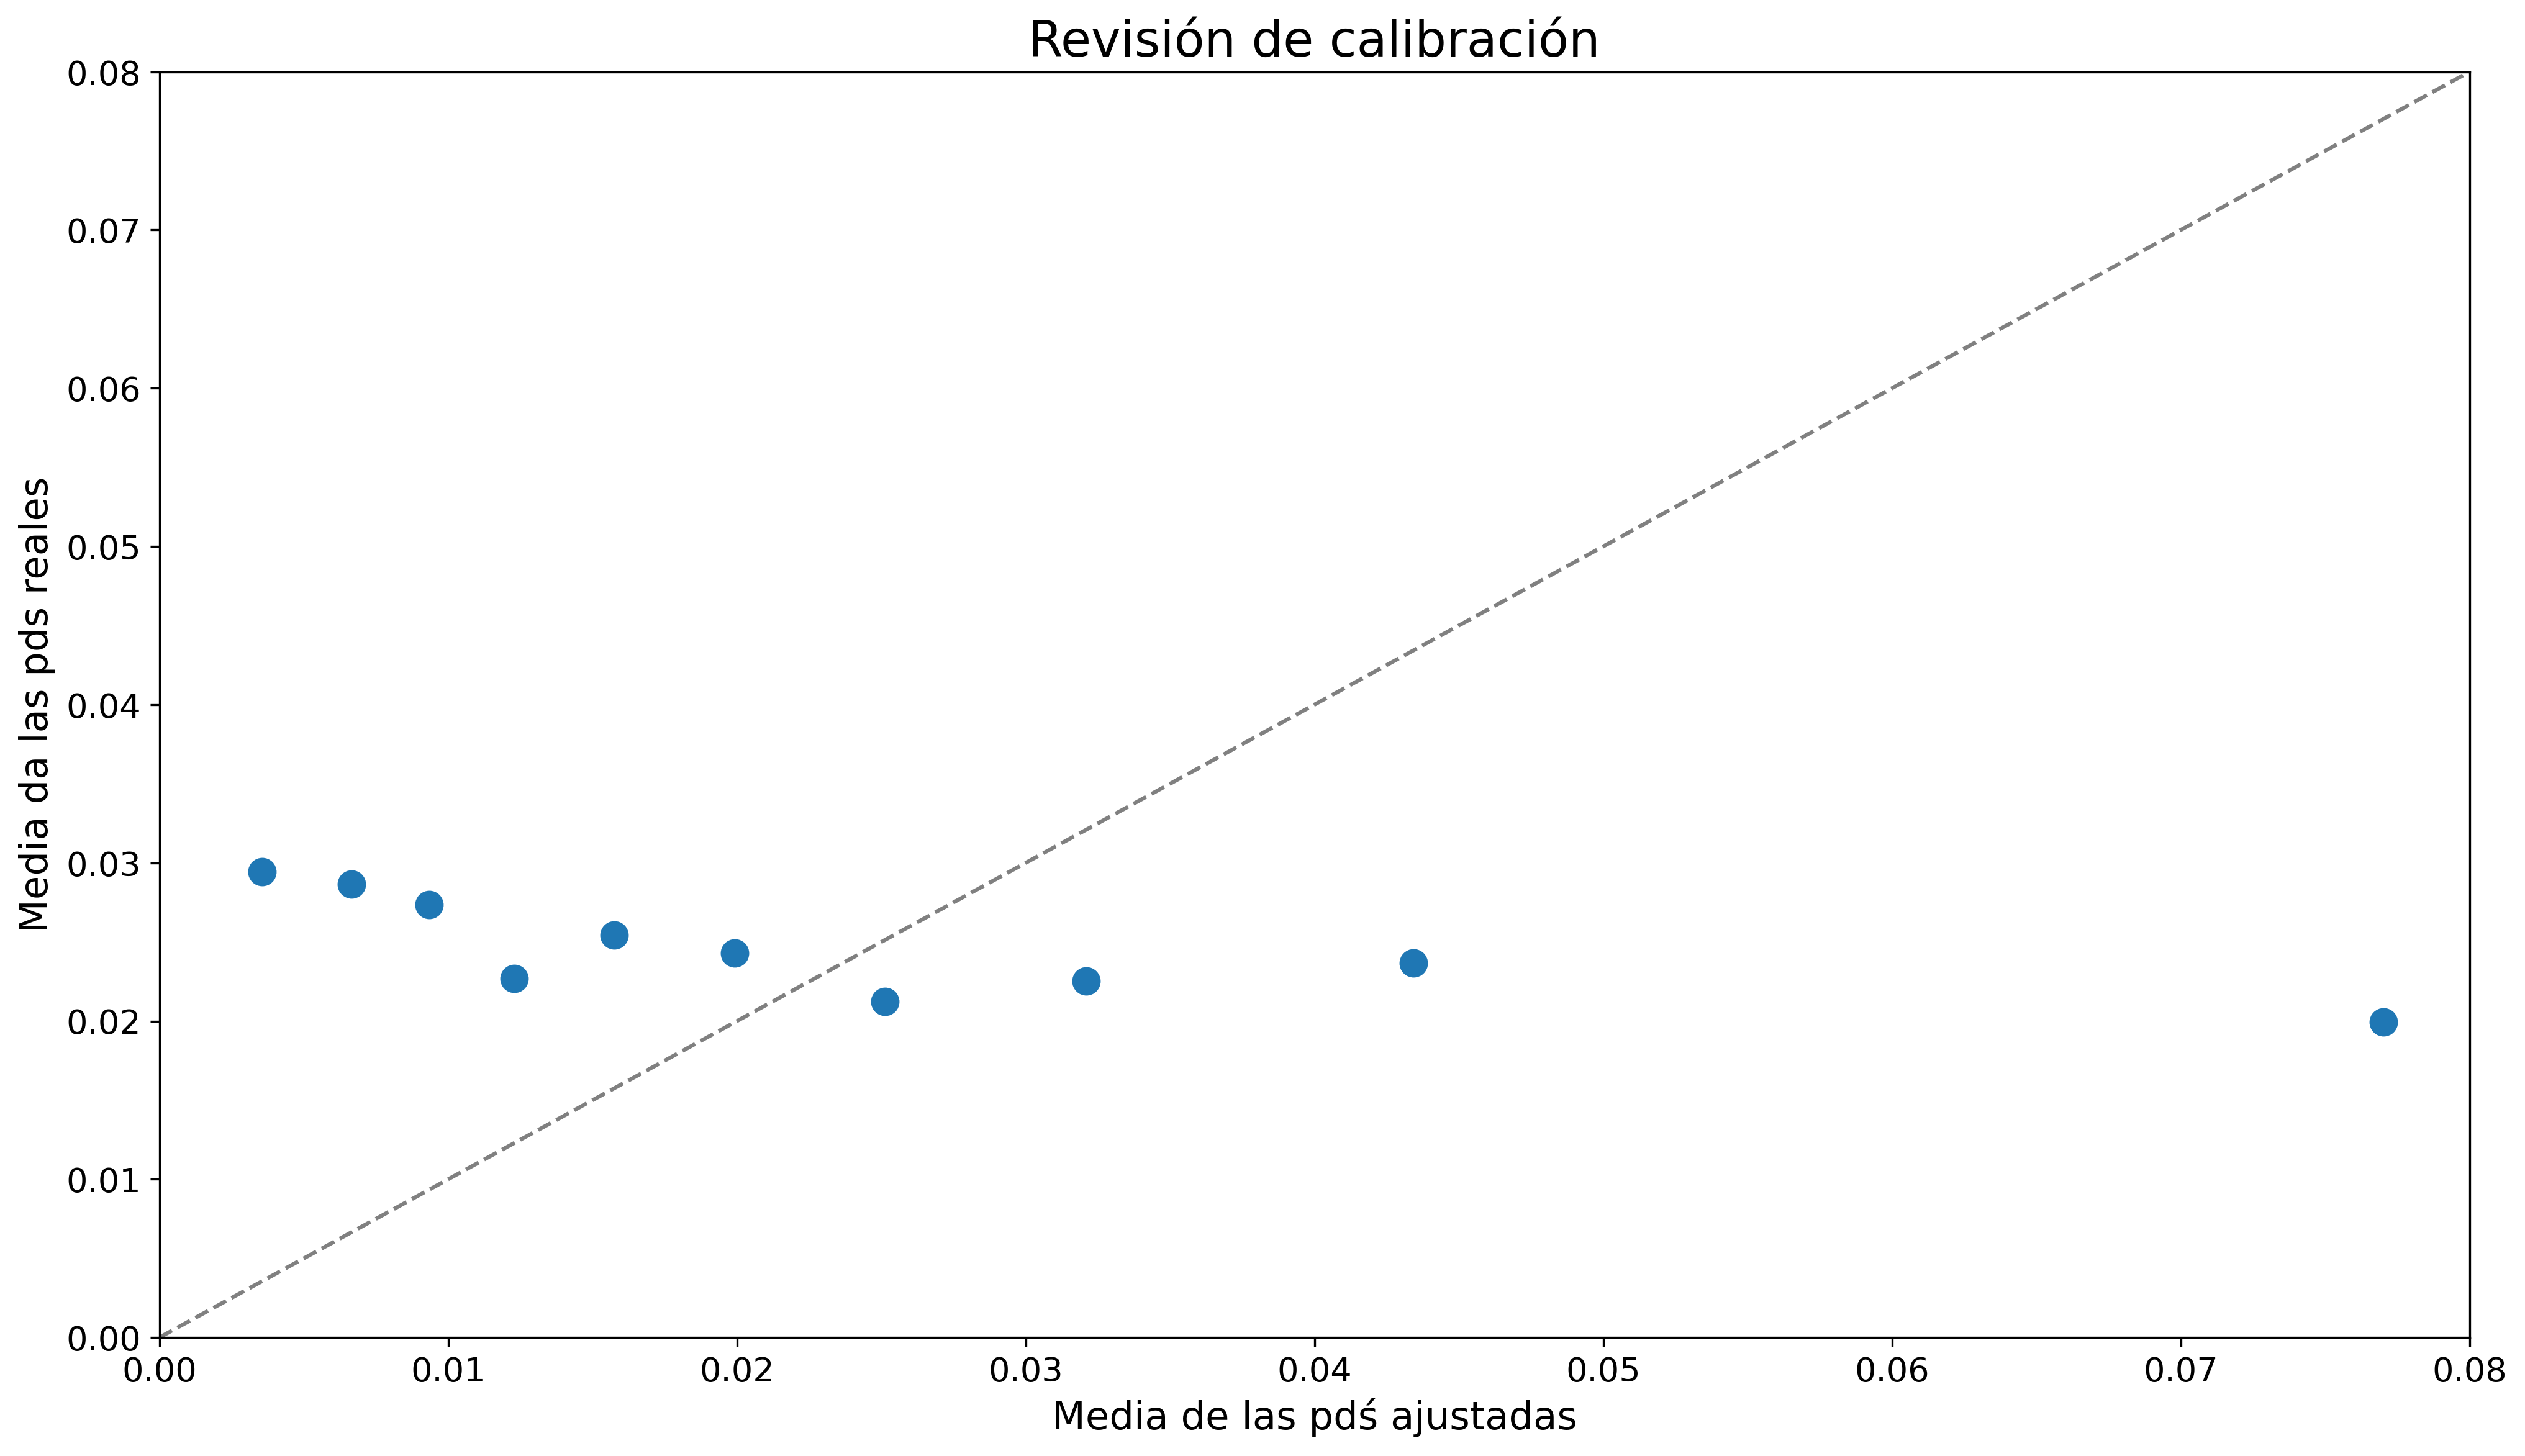

In [275]:
utils.grafica_ajuste(data2_cpa.PD_logit_model, data2_cpa.default_time, data2_cpa.time)